# Convolution Neural Networks

In [ ]:
#| default_exp models.conv

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch.nn as nn
import torch

from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateMonitor

from torch_lr_finder import LRFinder

from hydra.utils import instantiate
from omegaconf import OmegaConf

from matplotlib import pyplot as plt
import pandas as pd
from typing import List, Optional, Type

from nimrod.utils import get_device
from nimrod.models.core import Classifier

import logging
logger = logging.getLogger(__name__)

## Overview
A lightweight, flexible Convolutional Neural Network (CNN) implementation using PyTorch, designed for image recognition tasks.

## Core Components

### ConvLayer
A customizable convolutional layer with unique downsampling strategy:
- Uses stride 2 convolution instead of traditional pooling
- Preserves more spatial information
- Optional ReLU activation

#### Key Parameters
- `in_channels`: Input channel count (default: 3)
- `out_channels`: Output channel count (default: 16)
- `kernel_size`: Convolution kernel size (default: 3)
- `activation`: Toggle ReLU activation (default: True)

### ConvNet
A sequential convolutional network for image classification:
- Progressive downsampling with ConvLayers
- Batch normalization after each layer
- Designed for MNIST-like image recognition

#### Network Architecture
- Input: Configurable input channels
- Layers: 5 ConvLayers with increasing channel depth
- Final layer: Flattened output for classification

## Features
- Dynamic network configuration
- Stride-based downsampling
- Batch normalization
- Flexible layer composition
- Logging integration

## Dependencies
- PyTorch
- Lightning
- Hydra
- OmegaConf

## Usage Example
```python
# Create ConvNet with custom configuration
convnet = ConvNet(
    in_channels=1,   # Grayscale images
    out_channels=10  # Number of classes
)

# Forward pass
output = convnet(input_tensor)
```

## Conv Layer

Using a convolution with a stride of 2 instead of max pooling essentially achieves the same goal of downsampling an image by reducing its spatial dimensions, but with the key difference that the convolution layer can learn more complex feature combinations from overlapping regions, while max pooling only selects the maximum value within a window, potentially losing information about the finer details within that region; making the convolution with stride approach often preferred for preserving more spatial information in a neural network. 

In [ ]:
#| export
class ConvLayer(nn.Module):
    """A 2D convolutional layer with optional batch normalization and activation.

    This layer performs 2D convolution with stride 2 for downsampling, optionally followed by
    batch normalization and activation.

    Parameters
    ----------
    in_channels : int, default=3
        Number of input channels
    out_channels : int, default=16 
        Number of output channels / number of features
    kernel_size : int, default=3
        Size of the convolving kernel
    bias : bool, default=True
        If True, adds a learnable bias to the convolution
    normalization : nn.Module, default=nn.BatchNorm2d
        Normalization layer to use after convolution
    activation : nn.Module, default=nn.ReLU
        Activation function to use after normalization

    Notes
    -----
    When using batch normalization, the convolution bias is automatically disabled
    since it would be redundant.

    The spatial dimensions are reduced by half due to stride=2 convolution:
    output_size = input_size/2
    """
  
    def __init__(
        self,
        in_channels:int=3, # input channels
        out_channels:int=16, # output channels
        kernel_size:int=3, # kernel size
        bias:bool=True,
        normalization:Optional[Type[nn.Module]]=nn.BatchNorm2d,
        activation:Optional[Type[nn.Module]]=nn.ReLU,
        
    ):

        super().__init__()
        
        if bias and normalization and issubclass(normalization, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
            logger.warning('setting conv bias to False as Batchnorm is used')
            # https://x.com/karpathy/status/1013245864570073090
            bias = None

        # use stride 2 for downsampling to (W/2, H/2) instead of max or average pooling with stride 1
        conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=kernel_size//2, bias=bias)
        layers = [conv]
        if normalization:
            if issubclass(normalization,  (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
                layers.append(normalization(out_channels))
        if activation: layers.append(activation())
        self.net = nn.Sequential(*layers)

    def forward(self, x:torch.Tensor # input image tensor of dimension (B, C, W, H)
                ) -> torch.Tensor: # output image tensor of dimension (B, C, W/2, H/2)
        return self.net(x)


In [ ]:
show_doc(ConvLayer.forward)

---

### ConvLayer.forward

>      ConvLayer.forward (x:torch.Tensor)

*Define the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | input image tensor of dimension (B, C, W, H) |
| **Returns** | **Tensor** | **output image tensor of dimension (B, C, W/2, H/2)** |

### Usage

In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H,W)
# stride 2 layer downsample to (W/2, H/2)
net = ConvLayer(
    in_channels=C,
    out_channels=16,
    kernel_size=3,
    bias=True,
    normalization=None,
    activation=None,
    )
print(net)
print("Y: ",net(X).shape)
# # flatten all dims except batch dim 1
Y = torch.flatten(net(X), 1)
print(Y.shape)

ConvLayer(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)
Y:  torch.Size([64, 16, 14, 14])
torch.Size([64, 3136])


### Configs

In [ ]:
cfg = OmegaConf.load('../config/model/image/convlayer.yaml')
net = instantiate(cfg.defaults)
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H,W)
print(net)
print("Y: ",net(X).shape)

[22:06:16] WARNING - setting conv bias to False as Batchnorm is used


ConvLayer(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)
Y:  torch.Size([64, 16, 14, 14])


## Convnet Model
Simple convolution network for image recognition

In [ ]:
#| export

class ConvNet(nn.Module):

    def __init__(
            self,
            n_features:List[int]=[1, 8, 16, 32, 64], # channel/feature expansion
            num_classes:int=10, # num_classes
            kernel_size:int=3, # kernel size
            bias:bool=False, # conv2d bias
            normalization:nn.Module=nn.BatchNorm2d, # normalization (before activation)
            activation:nn.Module=nn.ReLU, # activation function
        ):

        super().__init__()

        net = nn.ModuleList()
        for i in range(len(n_features) - 1):
            conv = ConvLayer(
                    in_channels=n_features[i],
                    out_channels=n_features[i+1],
                    kernel_size=kernel_size,
                    bias=bias,
                    normalization=normalization,
                    activation=activation
            )
            net.append(conv)
       
        net.append(
            ConvLayer(
                in_channels=n_features[-1],
                out_channels=num_classes,
                kernel_size=kernel_size,
                bias=True,
                normalization=None,
                activation=None
                )
            )
        net.append(nn.Flatten(start_dim=1, end_dim=-1))

        self.net = nn.Sequential(*net)


    def forward(
        self,
        x:torch.Tensor # input image tensor of dimension (B, C, W, H)
        ) -> torch.Tensor: # output probs (B, N_classes)
        return self.net(x)

In [ ]:
show_doc(ConvNet.forward)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/conv.py#L115){target="_blank" style="float:right; font-size:smaller"}

### ConvNet.forward

>      ConvNet.forward (x:torch.Tensor)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | input image tensor of dimension (B, C, W, H) |
| **Returns** | **Tensor** | **output probs (B, N_classes)** |

### Usage

#### Mock data

In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape

torch.Size([64, 1, 28, 28])

#### Model

In [ ]:
# model instantiation
convnet = ConvNet(
            n_features=[1, 8, 16, 32, 64], # channel/feature expansion
            num_classes=10, # num_classes
            kernel_size=3, # kernel size
            bias=False, # conv2d bias
            normalization=nn.BatchNorm2d, # normalization (before activation)
            activation=nn.ReLU,
)
out = convnet(X)
print(out.shape)

# from config
cfg = OmegaConf.load('../config/model/image/convnet.yaml')
print(cfg.defaults)
convnet = instantiate(cfg.defaults)
# print(convnet(X).shape)

torch.Size([64, 10])
{'_target_': 'nimrod.models.conv.ConvNet', 'n_features': [1, 8, 16, 32, 64], 'num_classes': 10, 'kernel_size': 3, 'bias': False, 'normalization': {'_target_': 'hydra.utils.get_class', 'path': 'torch.nn.BatchNorm2d'}, 'activation': {'_target_': 'hydra.utils.get_class', 'path': 'torch.nn.ReLU'}}


### Training

#### Dataloaders

In [ ]:
#| notest

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')

datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.batch_size = 2048
datamodule.setup()

# one data point 
X,y = datamodule.test_ds[0]
print("X (C,H,W): ", X.shape, "y: ", y)

# a batch of data via dataloader
XX,YY = next(iter(datamodule.test_dataloader()))
print("XX (B,C,H,W): ", XX.shape, "YY: ", YY.shape)

print(len(datamodule.train_ds))
print(len(datamodule.train_ds)//cfg.datamodule.batch_size)

[22:21:23] INFO - PyTorch version 2.5.1 available.
Seed set to 42
[22:21:26] INFO - Init ImageDataModule for mnist
[22:21:26] INFO - mnist Dataset: init
[22:21:32] INFO - mnist Dataset: init
[22:21:36] INFO - split train into train/val [0.8, 0.2]
[22:21:36] INFO - train: 48000 val: 12000, test: 10000


X (C,H,W):  torch.Size([1, 28, 28]) y:  7
XX (B,C,H,W):  torch.Size([64, 1, 28, 28]) YY:  torch.Size([64])
48000
750


#### Model & hardware

In [ ]:
device = get_device()
print(device)
model = ConvNet()
model = model.to(device)

[22:24:07] INFO - Using device: mps
[22:24:07] WARNING - setting conv bias to False as Batchnorm is used
[22:24:07] WARNING - setting conv bias to False as Batchnorm is used
[22:24:07] WARNING - setting conv bias to False as Batchnorm is used
[22:24:07] WARNING - setting conv bias to False as Batchnorm is used


mps


#### Loss, optimizer, scheduler

##### LR finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.74E-03


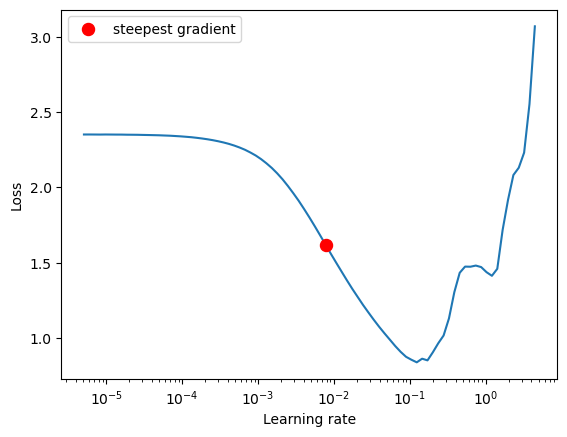

Suggested lr: 0.007742636826811274


In [ ]:
#| notest

criterion = nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
# Initialize LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
# Run LR range test
lr_finder.range_test(
    datamodule.train_dataloader(),
    start_lr=1e-6,      # Extremely small starting learning rate
    end_lr=10,          # Large ending learning rate
    num_iter=100,   # Number of iterations to test
    smooth_f=0.05,   # Smoothing factor for the loss
    diverge_th=5, 
)
    
# Plot the learning rate vs loss
_, lr_found = lr_finder.plot(log_lr=True)
print('Suggested lr:', lr_found)
    
lr_finder.reset()
    

    

##### 1-cycle training loop

In [ ]:
#| notest

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.setup()

# device = 'cpu'
print(device)
model = ConvNet()
model = model.to(device)

N_EPOCHS = 5

lr_found = 7.74e-3 # from lr finder

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
steps_per_epoch = len(datamodule.train_ds) // cfg.datamodule.batch_size
total_steps = steps_per_epoch* N_EPOCHS
print(len(datamodule.train_ds), cfg.datamodule.batch_size, steps_per_epoch, total_steps)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epochs, epochs=1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr_found,  # Peak learning rate
        # total_steps=len(datamodule.train_ds) * N_EPOCHS,  # Total training iterations
        steps_per_epoch=steps_per_epoch,
        epochs=N_EPOCHS,
        pct_start=0.3,  # 30% of training increasing LR, 70% decreasing
        anneal_strategy='cos',  # Cosine annealing
        div_factor=10,  # Initial lr = max_lr / div_factor
        # final_div_factor=1e4,
        three_phase=False  # Two phase LR schedule (increase then decrease)
    )

%time
losses = []
lrs = []
current_step = 0

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in datamodule.train_dataloader():
        if current_step >= total_steps:
            print(f"Reached total steps: {current_step}/{total_steps}")
            break
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        scheduler.step()    
        current_step += 1
    
        losses.append(loss.item())
        # current_lr = scheduler.get_last_lr()[0]
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (i % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        i += 1
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.test_dataloader():
            # model expects input (B,H*W)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()

        # Print the accuracy
    print(f"Epoch {epoch + 1}: Loss {loss.item():.4f}, Accuracy = {100 * correct / total:.2f}%")
    # print(f'Current LR: {optimizer.param_groups[0]["lr"]:.5f}')



[22:24:46] INFO - Init ImageDataModule for mnist
[22:24:46] INFO - mnist Dataset: init
[22:24:52] INFO - mnist Dataset: init
[22:24:55] INFO - split train into train/val [0.8, 0.2]
[22:24:55] INFO - train: 48000 val: 12000, test: 10000
[22:24:55] WARNING - setting conv bias to False as Batchnorm is used
[22:24:55] WARNING - setting conv bias to False as Batchnorm is used
[22:24:55] WARNING - setting conv bias to False as Batchnorm is used
[22:24:55] WARNING - setting conv bias to False as Batchnorm is used


mps
48000 2048 23 115
CPU times: user 7 μs, sys: 1e+03 ns, total: 8 μs
Wall time: 1.91 μs
Loss 2.3578, Current LR: 0.0007893044, Step: 1/115
Epoch 1: Loss 0.3190, Accuracy = 91.90%
Loss 0.2454, Current LR: 0.0066908139, Step: 25/115
Epoch 2: Loss 0.0902, Accuracy = 96.35%
Loss 0.0733, Current LR: 0.0070533036, Step: 49/115
Epoch 3: Loss 0.0589, Accuracy = 98.02%
Loss 0.0611, Current LR: 0.0039832943, Step: 73/115
Epoch 4: Loss 0.0542, Accuracy = 98.43%
Loss 0.0412, Current LR: 0.0008209842, Step: 97/115
Reached total steps: 115/115
Epoch 5: Loss 0.0367, Accuracy = 98.44%


[<matplotlib.lines.Line2D>]

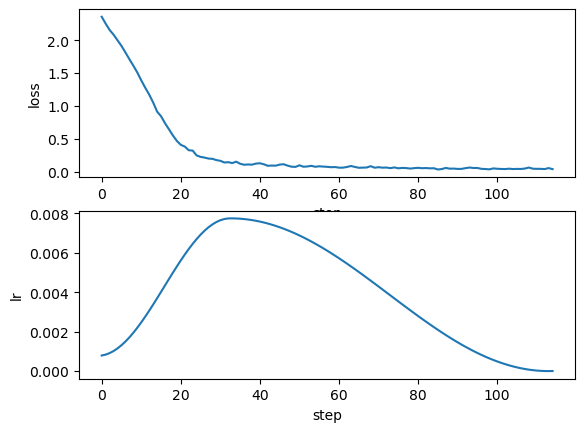

In [ ]:
#| notest
plt.figure(1)
plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(losses)
plt.subplot(212)
plt.ylabel('lr')
plt.xlabel('step')
plt.plot(lrs)

## ConvNetX

In [ ]:
#| export

class ConvNetX(Classifier, LightningModule):
    def __init__(
            self,
            nnet:ConvNet,
            num_classes:int,
            optimizer:torch.optim.Optimizer,
            scheduler:torch.optim.lr_scheduler,
            ):
        logger.info("ConvNetX: init")
        super().__init__(num_classes, optimizer, scheduler)
        self.register_module('nnet', nnet)
        self.save_hyperparameters(logger=False, ignore=['nnet'])
        self.lr = optimizer.keywords['lr'] # for lr finder
        self.nnet = nnet

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)

### Usage

In [ ]:
cfg = OmegaConf.load('../config/model/image/conv.yaml')
model = instantiate(cfg)

[22:29:50] INFO - ConvNetX: init
[22:29:50] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape
print(model(X).shape)

torch.Size([64, 10])


### Nimrod training

In [ ]:
# model
model_cfg = OmegaConf.load('../config/model/image/conv.yaml')
model = instantiate(model_cfg)

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
cfg.datamodule.num_workers = 0
datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.setup()

[22:30:11] INFO - ConvNetX: init
[22:30:11] INFO - Classifier: init
[22:30:11] INFO - Init ImageDataModule for mnist
[22:30:11] INFO - mnist Dataset: init
[22:30:16] INFO - mnist Dataset: init
[22:30:19] INFO - split train into train/val [0.8, 0.2]
[22:30:19] INFO - train: 48000 val: 12000, test: 10000


In [ ]:
dl = datamodule.test_dataloader()
print(next(iter(dl))[0].shape)
print(next(iter(dl))[1].shape)

torch.Size([2048, 1, 28, 28])
torch.Size([2048])


In [ ]:
N_EPOCHS = 5

trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    logger=TensorBoardLogger("tb_logs", name="mnist_convnet", default_hp_metric=True),
    # logger=CSVLogger("logs", name="mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[22:30:38] INFO - mnist Dataset: init
[22:30:42] INFO - mnist Dataset: init
[22:30:49] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
[22:30:49] INFO - Scheduler: <torch.optim.lr_scheduler.OneCycleLR object>
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:316: The lr scheduler dict contains the key(s) ['monitor', 'strict'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve perfor

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0091201083935591
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/.lr_find_8133d31b-b5e6-4c1e-bdd7-7707ec368303.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/.lr_find_8133d31b-b5e6-4c1e-bdd7-7707ec368303.ckpt


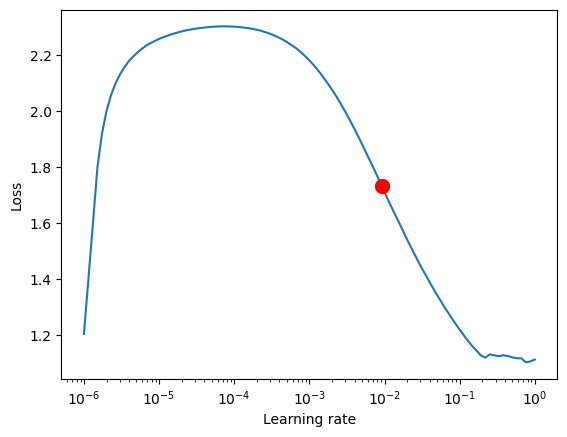

Suggested learning rate: 0.0091201083935591


In [ ]:
#| notest

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    datamodule=datamodule,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

In [ ]:
print(trainer.max_epochs, len(datamodule.train_ds), datamodule.hparams.batch_size)
print(5*56000)
print(5*56000/2048)
print(5*56000//2048)

5 60000 2048
280000
136.71875
136


In [ ]:
#| notest

N_EPOCHS = 5

trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    # logger=TensorBoardLogger("tb_logs", name="mnist_convnet", default_hp_metric=True),
    logger=CSVLogger("logs", name="mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )

print("estimated steps: ", trainer.estimated_stepping_batches, "accumulate_grad_batches: ", trainer.accumulate_grad_batches)
# model
model_cfg = OmegaConf.load('../config/model/image/conv.yaml')
model = instantiate(model_cfg)
steps_per_epoch = len(datamodule.train_ds) // cfg.datamodule.batch_size // trainer.accumulate_grad_batches
print("Steps per epoch: ", steps_per_epoch)
# model_cfg.scheduler.steps_per_epoch = steps_per_epoch
model_cfg.scheduler.epochs = N_EPOCHS 
# estimated_steps = N_EPOCHS * len(datamodule.train_ds) // cfg.datamodule.batch_size
model_cfg.scheduler.total_steps = trainer.max_epochs *len(datamodule.train_ds) // cfg.datamodule.batch_size
model_cfg.scheduler.max_lr = 0.32 #lr_finder.suggestion()
model_cfg.scheduler.pct_start = 0.3
model_cfg.scheduler.anneal_strategy = 'cos'
model_cfg.scheduler.div_factor = 10

model = instantiate(model_cfg)
print("LR: ",model.lr)

trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.
[22:31:34] INFO - ConvNetX: init
[22:31:34] INFO - Classifier: init
[22:31:34] INFO - ConvNetX: init
[22:31:34] INFO - Classifier: init
[22:31:34] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
[22:31:34] INFO - Scheduler: <torch.optim.lr_scheduler.OneCycleLR object>

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | M

estimated steps:  -1 accumulate_grad_batches:  1
Steps per epoch:  29
LR:  0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[22:31:47] WARNING - Max steps reached for 1-cycle LR scheduler
[22:31:47] WARNING - Max steps reached for 1-cycle LR scheduler
[22:31:47] WARNING - Max steps reached for 1-cycle LR scheduler
[22:31:47] WARNING - Max steps reached for 1-cycle LR scheduler


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()

,epoch,lr-Adam,step,train/acc_epoch,train/acc_step,train/loss_epoch,train/loss_step,val/acc,val/acc_best,val/loss
0,NaN,0.032000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,0,NaN,0.102051,NaN,2.306412,NaN,NaN,NaN
2,NaN,0.032388,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1,NaN,0.103516,NaN,2.740687,NaN,NaN,NaN
4,NaN,0.033549,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


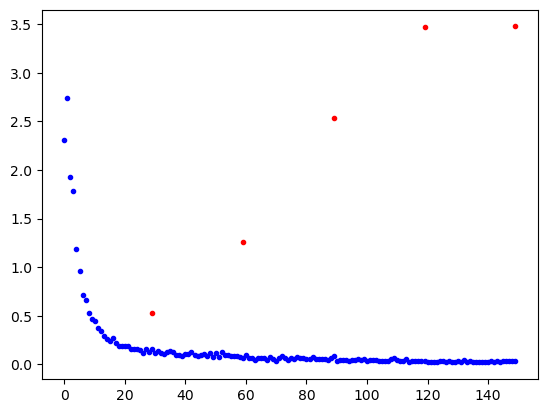

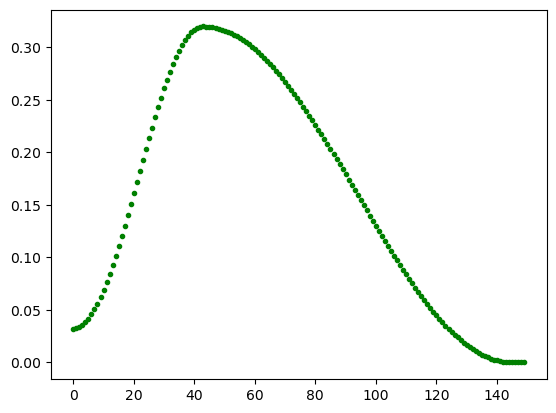

In [ ]:
#| notest
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.figure()
plt.plot(metrics['step'], metrics['lr-Adam'], 'g.-')
plt.show()

In [ ]:
#| notest
trainer.test(model, datamodule.test_dataloader(), ckpt_path="best")

Restoring states from the checkpoint path at logs/mnist_convnet/version_17/checkpoints/epoch=4-step=146.ckpt
Loaded model weights from the checkpoint at logs/mnist_convnet/version_17/checkpoints/epoch=4-step=146.ckpt
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9883999824523926     │
│         test/loss         │    0.03977206349372864    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.03977206349372864, 'test/acc': 0.9883999824523926}]

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()